# DeepBox

## First we need to import a few things, this includes our generator and visualizing module

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os
sys.path.append('..')
from Base_Deeplearning_Code.Visualizing_Model.Visualing_Model import visualization_model_class
%matplotlib inline

ModuleNotFoundError: No module named 'matplotlib'

## What do we need? We need a way to generate larges amounts of training data for our model..

In [ ]:
from Shape_Maker import Data_Generator, make_rectangle, make_circle
image_size = 64

## The make_rectangle and make_circle will both return circles and rectangles, and the Data_Generator will randomly create circles or rectangles

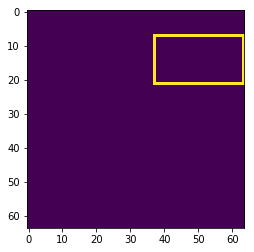

In [21]:
plt.imshow(make_rectangle(image_size))

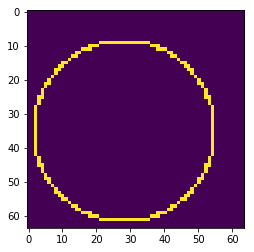

In [5]:
plt.imshow(make_circle(image_size))

### Our generator essentially continiously creates examples

In [22]:
train_generator = Data_Generator(image_size=image_size,batch_size=32, num_examples_per_epoch=150)

In [23]:
x,y = train_generator.__getitem__(0)
print(x.shape)
print(y.shape)

(32, 64, 64, 1)
(32, 2)


## Now lets make our network!

In [25]:
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Activation
from keras.optimizers import Adam
import tensorflow as tf
import keras.backend as K
from tensorflow import Graph, Session, ConfigProto, GPUOptions

### This will make sure multiple networks don't clog up the GPU

In [26]:
def prep_network():
    K.clear_session()
    gpu_options = tf.GPUOptions(allow_growth=True)
    sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options, log_device_placement=False))
    K.set_session(sess)
    return None

### Representation of network

![DeepBox_Network.png](./DeepBox_Network.png)

### Building the network

In [28]:
prep_network()
num_kernels = 4
kernel_size = (3,3)
model = Sequential([
    Conv2D(num_kernels, kernel_size, 
           input_shape=(image_size, image_size, 1), 
           padding='same',name='Conv_0',activation='sigmoid'),
    MaxPool2D((image_size)), # Pool into a 1x1x4 image
    Flatten(),
    Dense(2,activation='softmax')
])

### Defining loss
#### We are specifying that we care about the categorical cross entropy, with a learning rate of 0.1 (very high)

In [29]:
model.compile(Adam(lr=1e-1), loss='categorical_crossentropy', metrics=['accuracy'])

W0127 09:53:51.070087 20356 deprecation_wrapper.py:119] From C:\Users\bmanderson\AppData\Roaming\Python\Python36\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



### Train
#### We give the model our generator, and tell it to run for 5 epochs

In [30]:
model.fit_generator(train_generator,epochs=5)

W0127 09:54:00.022019 20356 deprecation.py:323] From c:\users\bmanderson\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5
150/150 [==============================] - 2s 14ms/step - loss: 0.1596 - acc: 0.9275
Epoch 2/5
150/150 [==============================] - 2s 12ms/step - loss: 0.0036 - acc: 1.0000
Epoch 3/5
150/150 [==============================] - 2s 13ms/step - loss: 0.0015 - acc: 1.0000
Epoch 4/5
150/150 [==============================] - 2s 12ms/step - loss: 9.0738e-04 - acc: 1.0000
Epoch 5/5
150/150 [==============================] - 2s 13ms/step - loss: 5.8397e-04 - acc: 1.0000


### Evaluate
### We will randomly create 500 examples of rectangles and circles and see how well our model does

In [31]:
def determine_accuracy(model, image_size= 64, num_examples=1000):
    truth = np.zeros((num_examples,1))
    guess = np.zeros((num_examples,1))
    index = 0
    for _ in range(num_examples//2):
        pred = model.predict(make_rectangle(image_size)[None,...,None])
        guess[index] = np.argmax(pred)
        truth[index] = 1
        index += 1
    for _ in range(num_examples//2):
        pred = model.predict(make_circle(image_size)[None,...,None])
        guess[index] = np.argmax(pred)
        index += 1
    print('Accuracy is {} for {} examples'.format(str((guess==truth).sum()/num_examples),num_examples))

In [32]:
determine_accuracy(model)

Accuracy is 1.0 for 1000 examples


### Lets see how confident it is in it's predictions, generate a random circle or rectangle and see what the confidence is

In [35]:
rectangle = make_rectangle(image_size)[None,...,None]
circle = make_circle(image_size)[None,...,None]
print('{}% confident'.format(model.predict(rectangle)[...,1][0]*100))
print('{}% confident'.format(model.predict(circle)[...,0][0]*100))

99.93405938148499% confident
99.99362230300903% confident


## Lets see what the kernels and activations look like

In [36]:
Visualizing_Class = visualization_model_class(model=model)

Conv_0
max_pooling2d_1
flatten_1
dense_1


### Say that we only want to look at Conv_0

In [38]:
Visualizing_Class.define_desired_layers(desired_layer_names=['Conv_0'])

## Kernels

Conv_0


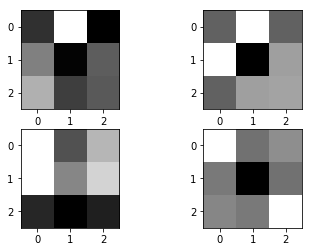

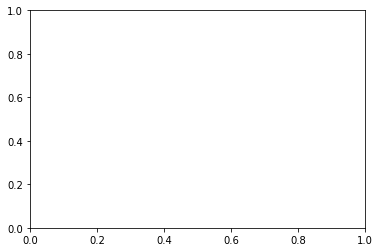

In [39]:
Visualizing_Class.plot_kernels()

## Activations
### In order to make an activation map we need to provide it with something to predict on

In [40]:
Visualizing_Class.predict_on_tensor(make_rectangle(image_size)[None,...,None])

['Conv_0']
Conv_0
0.0


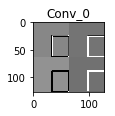

In [41]:
Visualizing_Class.plot_activations()

## How big is this model? Super tiny!!

In [42]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_0 (Conv2D)              (None, 64, 64, 4)         40        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 4)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 10        
Total params: 50
Trainable params: 50
Non-trainable params: 0
_________________________________________________________________
